# Plot some OLBIN publication database

#### Load modules and define common functions

In [1]:
#!pip install pandas matplotlib ipympl requests

# load some modules for later use
import requests
import pandas
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict 

%matplotlib inline

# define some common plot settings
plt.rcParams['figure.figsize'] = [17, 8]
# Set the default color cycle
colormap = plt.get_cmap('tab20').colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colormap) 
plt.rc('font', size=20)


# define a stack plot function
def plotStackedOlbinTags(tags,title, min_year, max_year=None ):    
    if not min_year:
        min_year = min(olbin.YEAR)
    
    if not max_year:
        max_year = max(olbin.YEAR)+1
        
    xticksNb = int( (max_year-min_year) / 12 )
    print("%d xticks for %d %d"%(xticksNb, min_year, max_year))
    
    cols = {}
    for (k,v) in olbin.items():
        if k in tags:
            cols[k]=v

    #split into 2 list given list's sum  " TODO make it adjustable param or detection of long input lists...
    sums=  OrderedDict( (key, sum(value)) for (key,value) in cols.items())
    sorted_by_sum= sorted(sums, key=sums.get)
    m=int(len(cols)/2)
    scols1=OrderedDict()
    scols2=OrderedDict()
    scols=OrderedDict()

    for name in reversed(sorted_by_sum):
        scols[name]=cols[name]
        if name in sorted_by_sum[0:m]:
            scols2[name]=cols[name]
        else:
            scols1[name]=cols[name]

    # loop overs subsets
    #subsets = (scols, scols1, scols2)
    subsets = (scols1, scols2)
    #subsets = [scols]
    # for stacked bars
    for scols in subsets:                
        fig, ax = plt.subplots()
        flag = True
        for c in scols:          
            if flag:
                ax.bar(olbin.YEAR, scols[c], label=c+" ("+str(sum(scols[c]))+")")
                flag=False
                bot=scols[c]
            else:
                ax.bar(olbin.YEAR, scols[c], bottom=bot, label=c+" ("+str(sum(scols[c]))+")")            
                bot= np.add(bot, scols[c]).tolist()                    
        ax.set_xlim(min_year,max_year)
        ax.set_xticks(np.arange(min_year,max_year, xticksNb))
        ax.legend(loc='upper left')    
        ax.set_title(title)
        fig.tight_layout()

    # for stacket plot    
    if False:
    #if True:
      for scols in subsets:        
        values=[]
        fig, ax = plt.subplots()
        for c in scols:
            values.append(scols[c])
        ax.stackplot(olbin.YEAR, values, labels=scols)
        ax.set_xlim(min_year,max_year)
        ax.set_xticks(np.arange(min_year,max_year, xticksNb))
        ax.legend(loc='upper left')        
        fig.tight_layout()


#### Load main dataset (csv format & json)

In [2]:
olbin = pandas.read_csv("http://bibdbmgr.jmmc.fr/tags.xql")
olbinAstro = pandas.read_csv("http://bibdbmgr.jmmc.fr/tags.xql?keep-tag=Astrophysical+results") # use keep-tag to get Astroresults dataset
categories = requests.get("http://bibdbmgr.jmmc.fr/categories.xql").json()
print("Olbin's categories are :\n\t %s" % ", ".join(categories.keys()))

Olbin's categories are :
	 HIDDEN, MainCategory, Instrument, Wavelength, Astrophysical topic, Technique, Facility, Spectral Resolution


# Display impact on scientific results for in general, on facilities with more than 25 papers and JMMC 

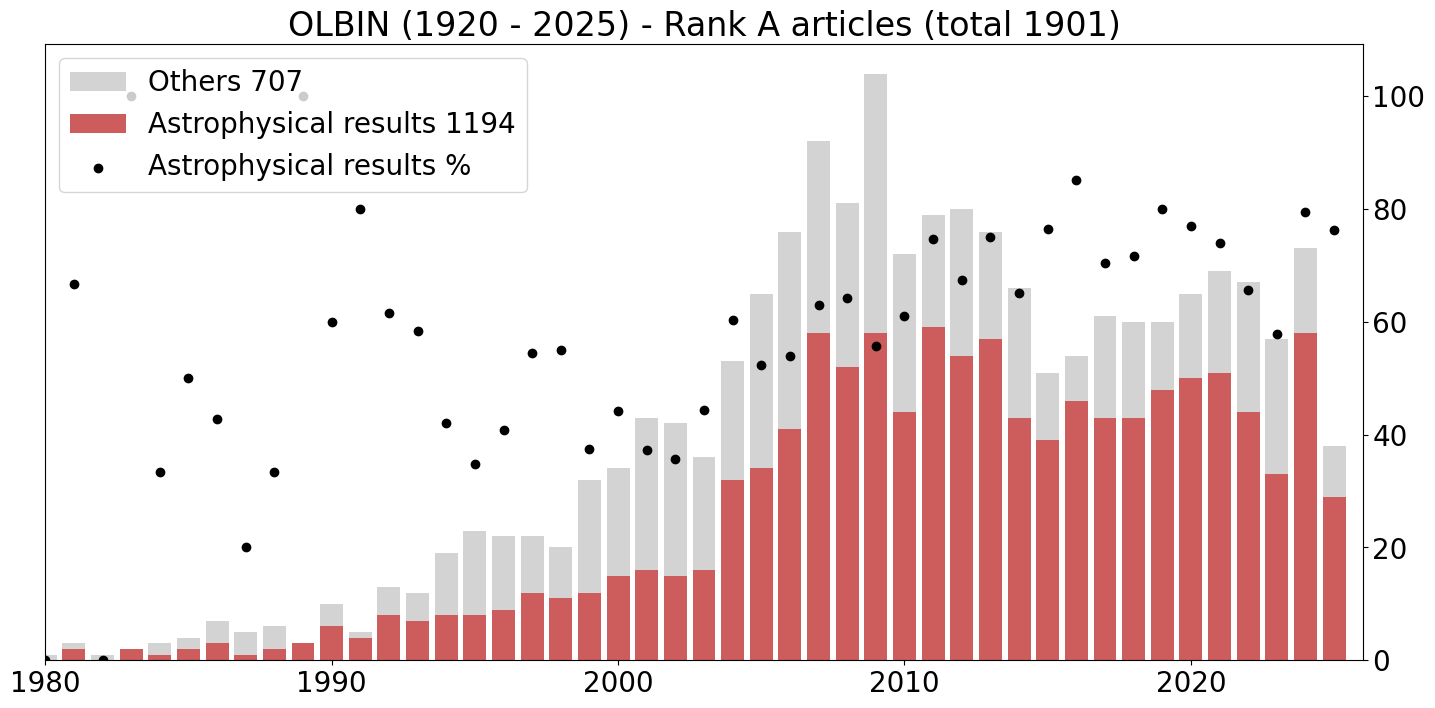

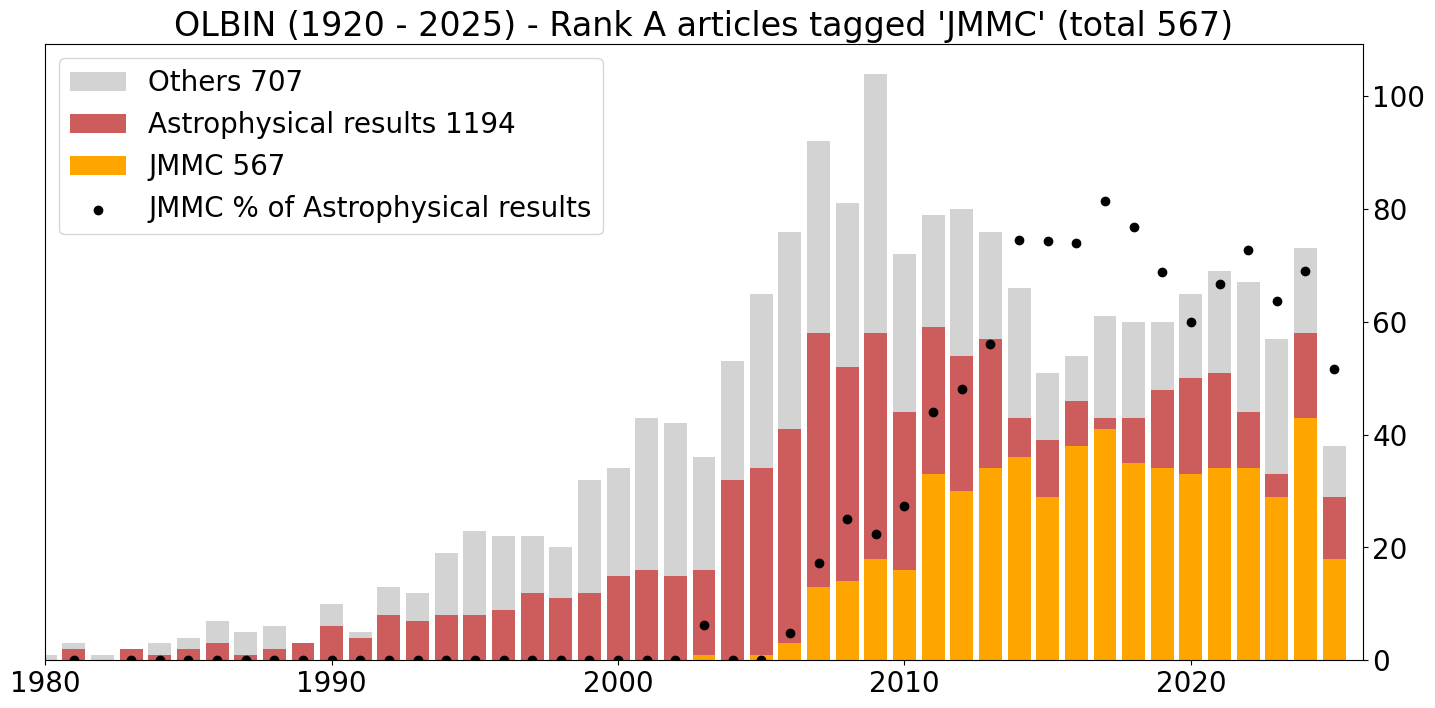

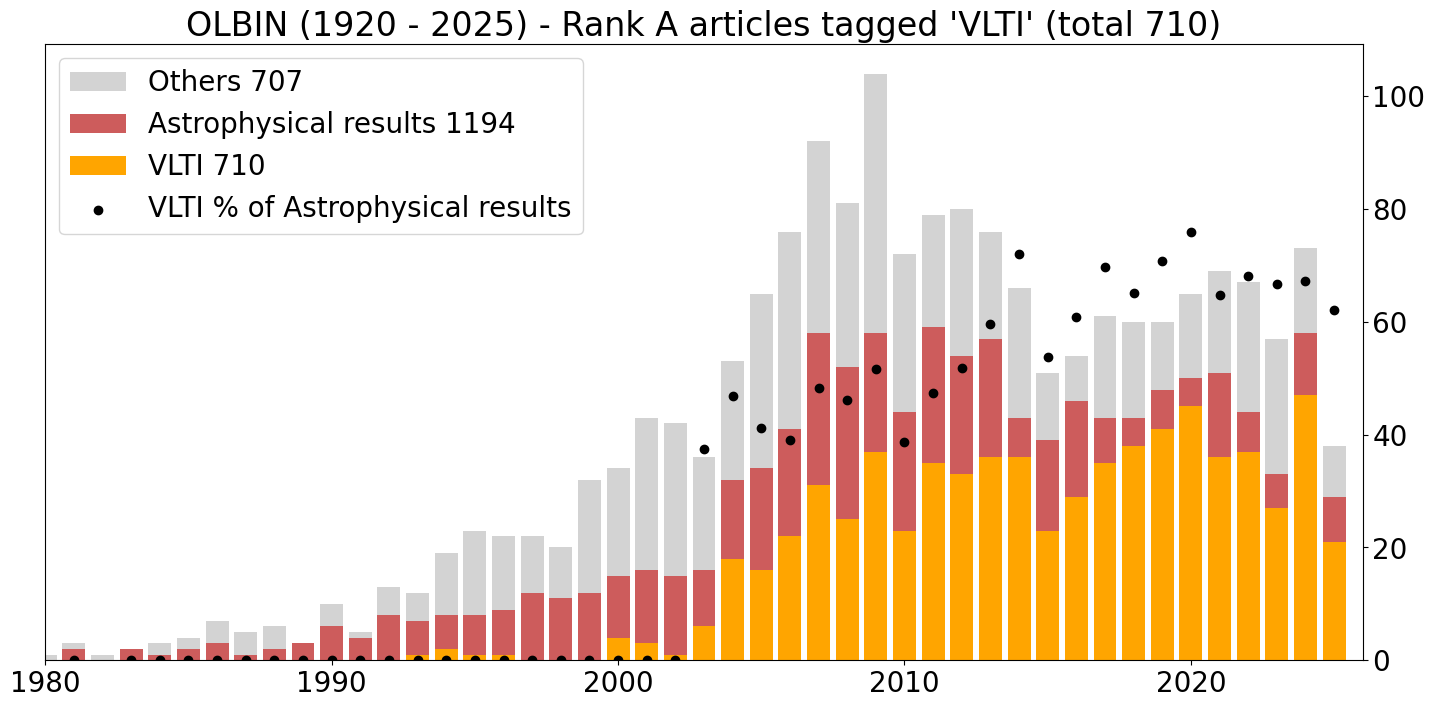

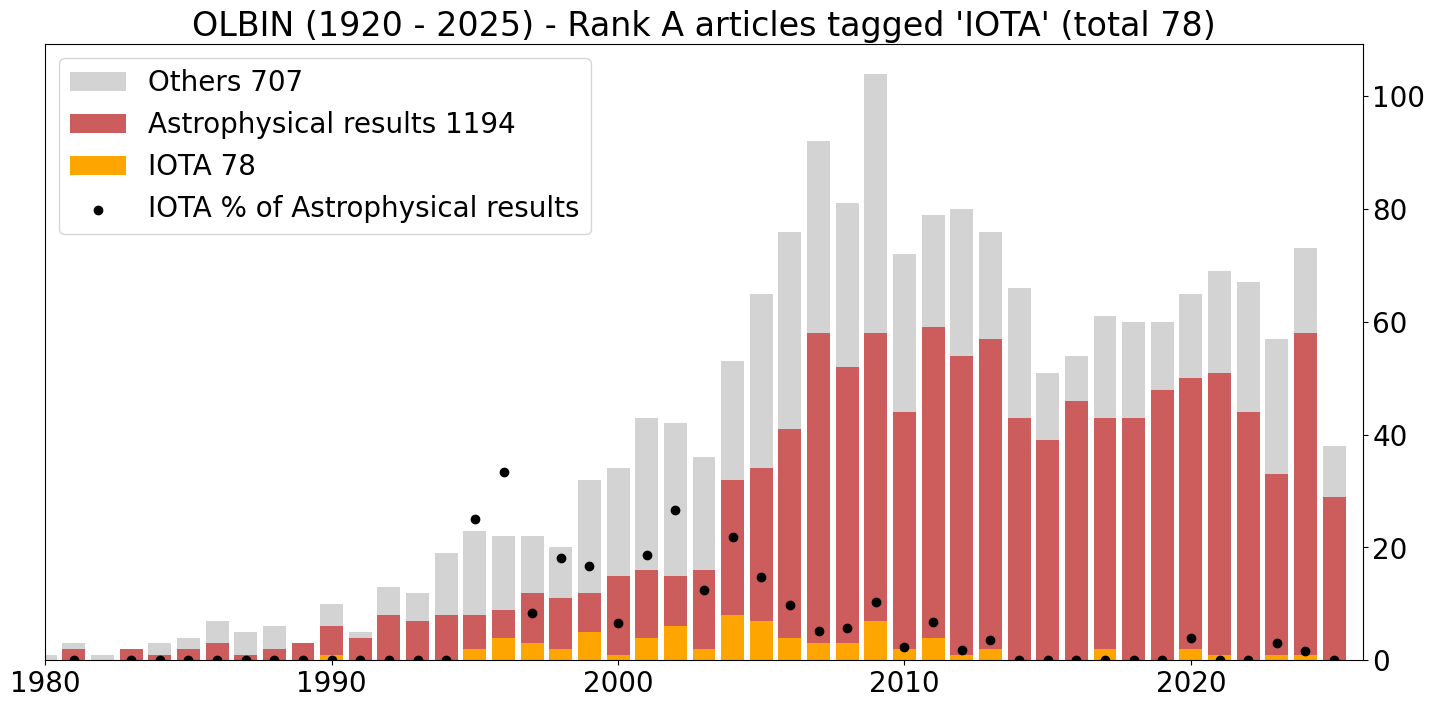

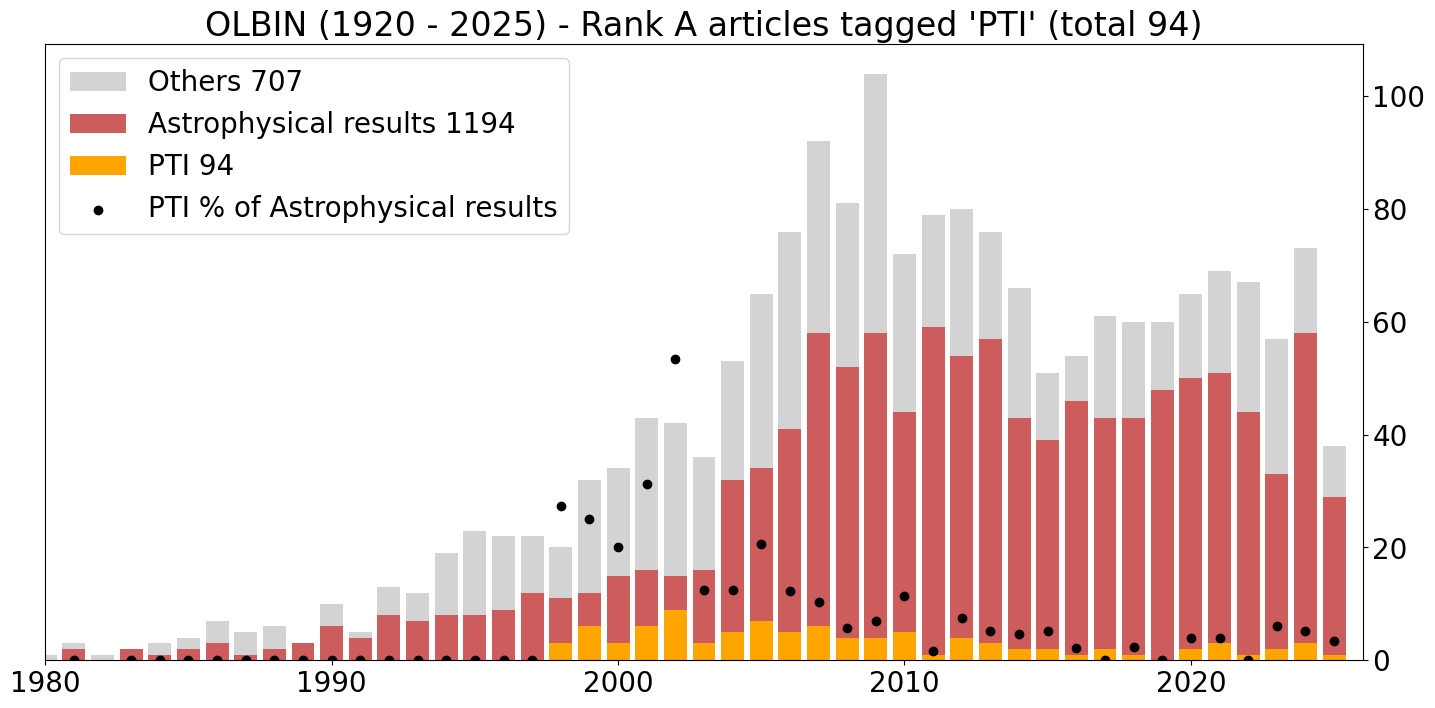

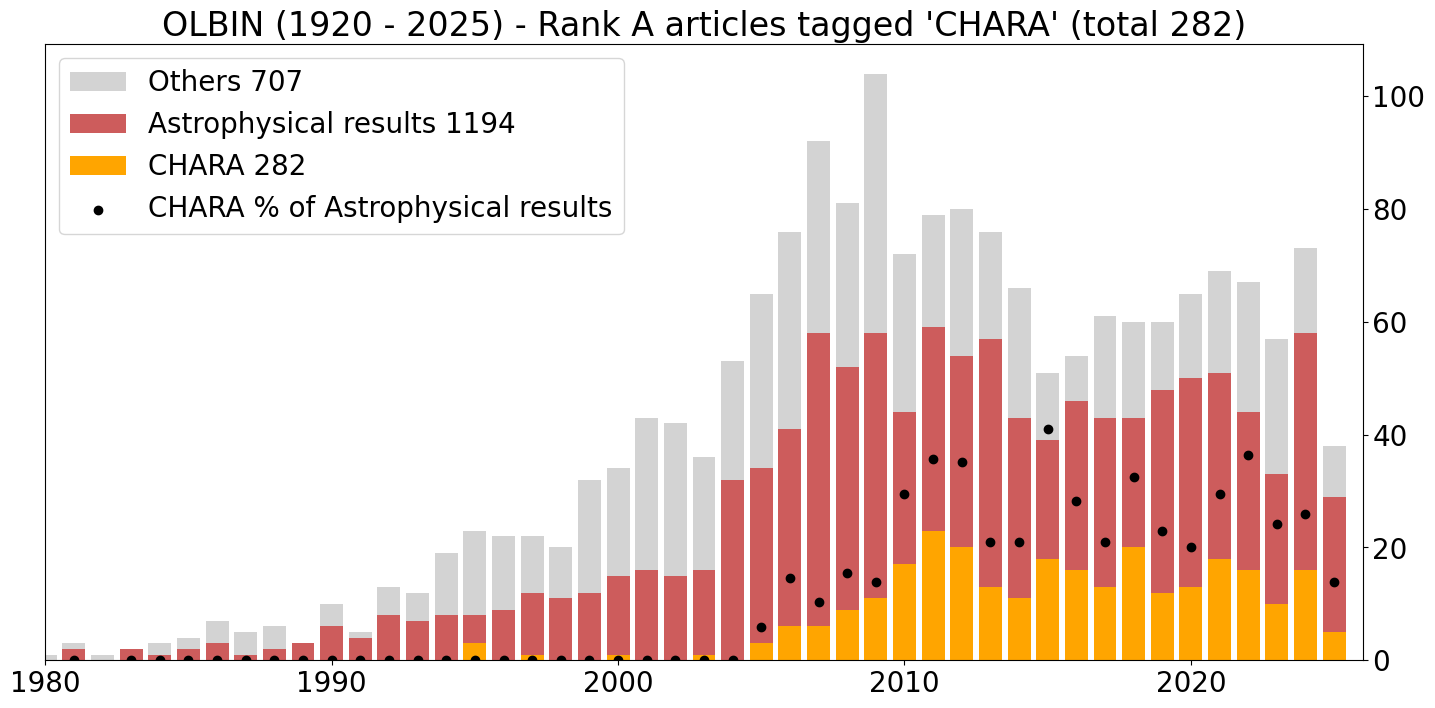

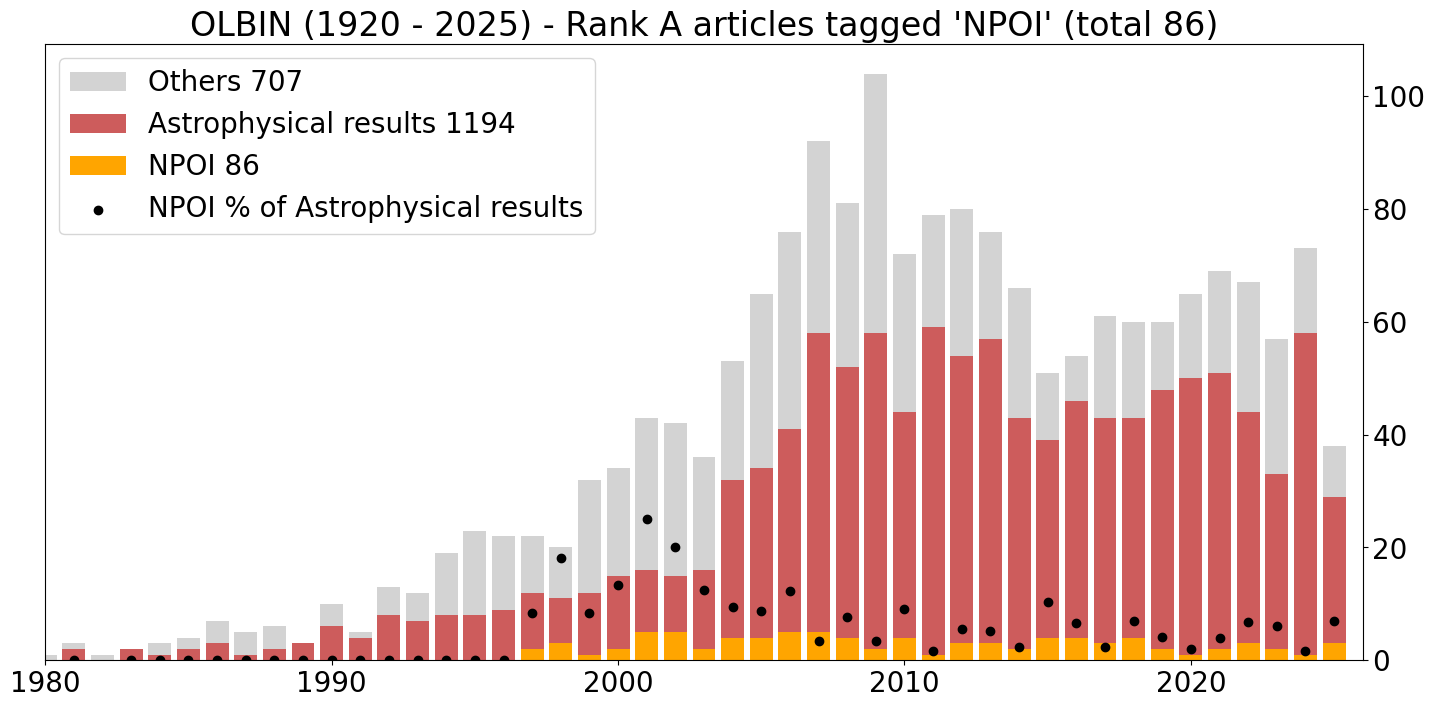

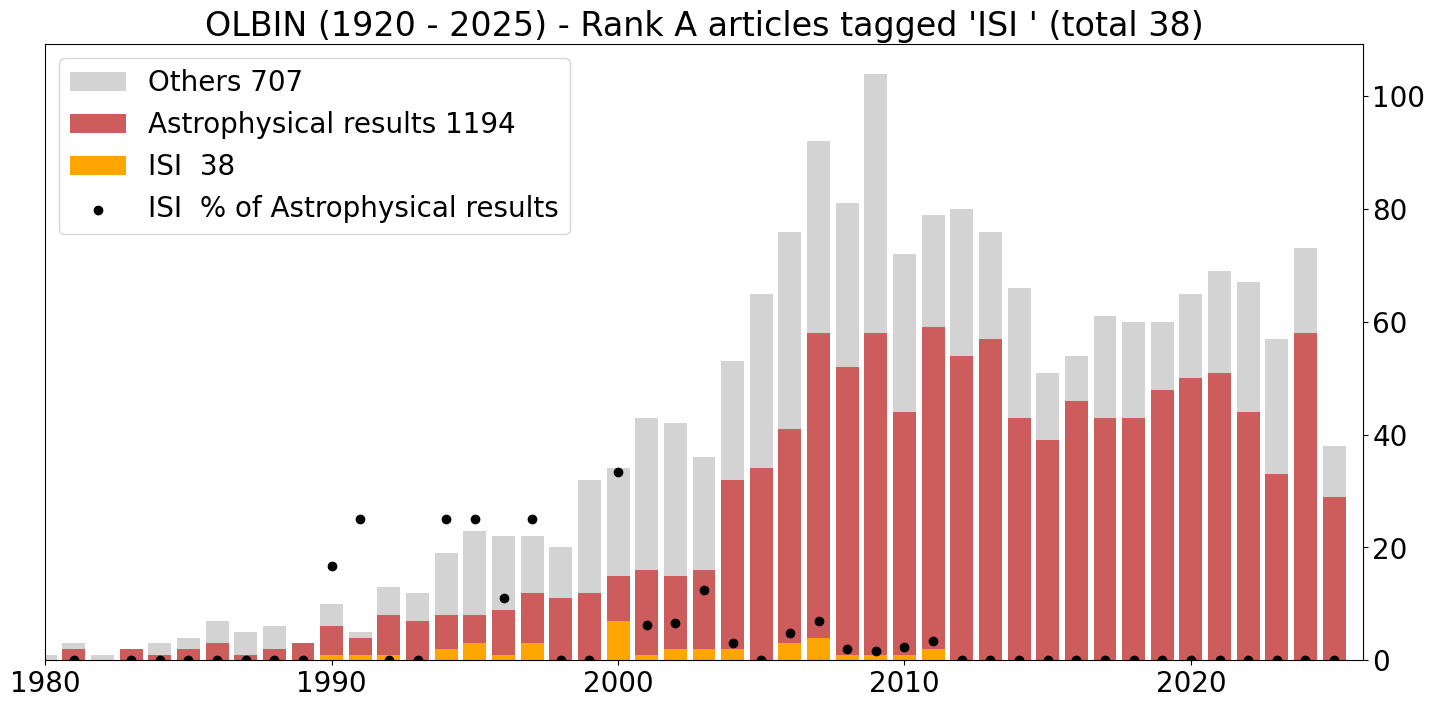

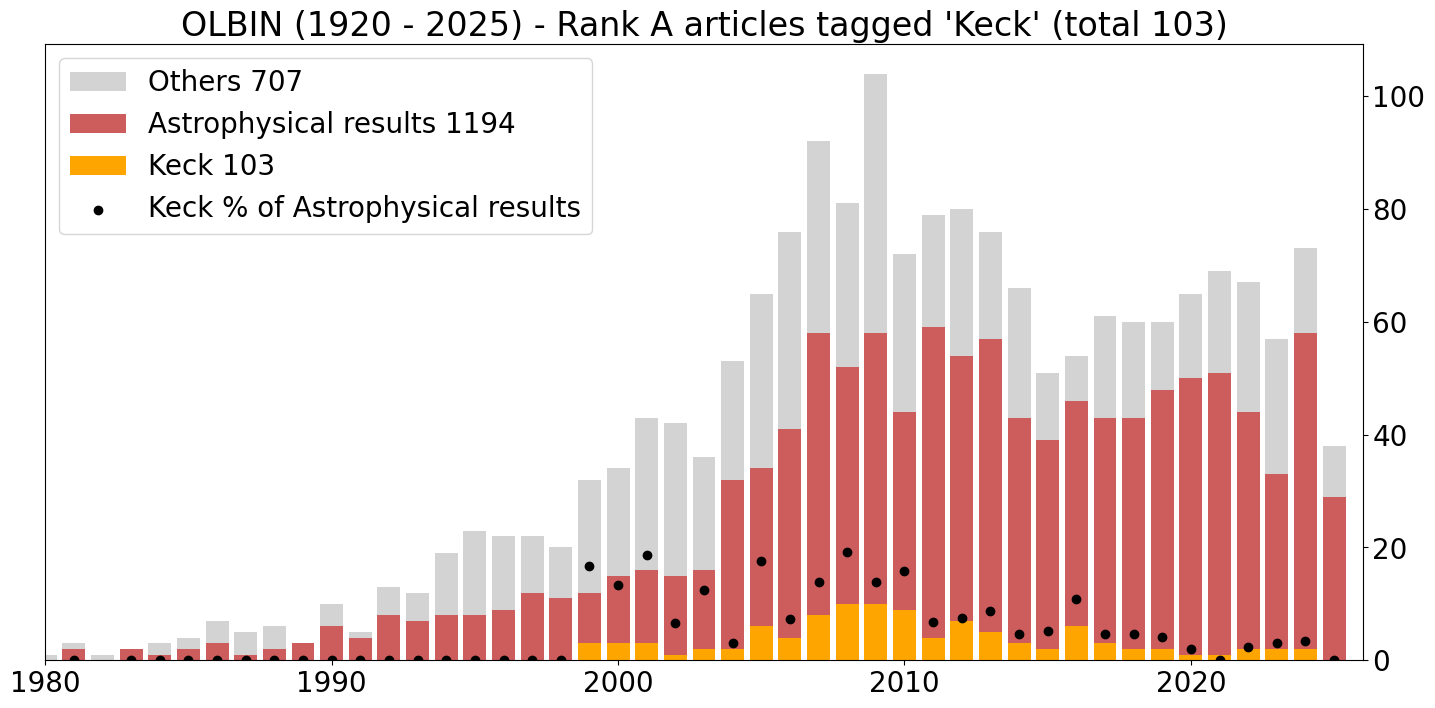

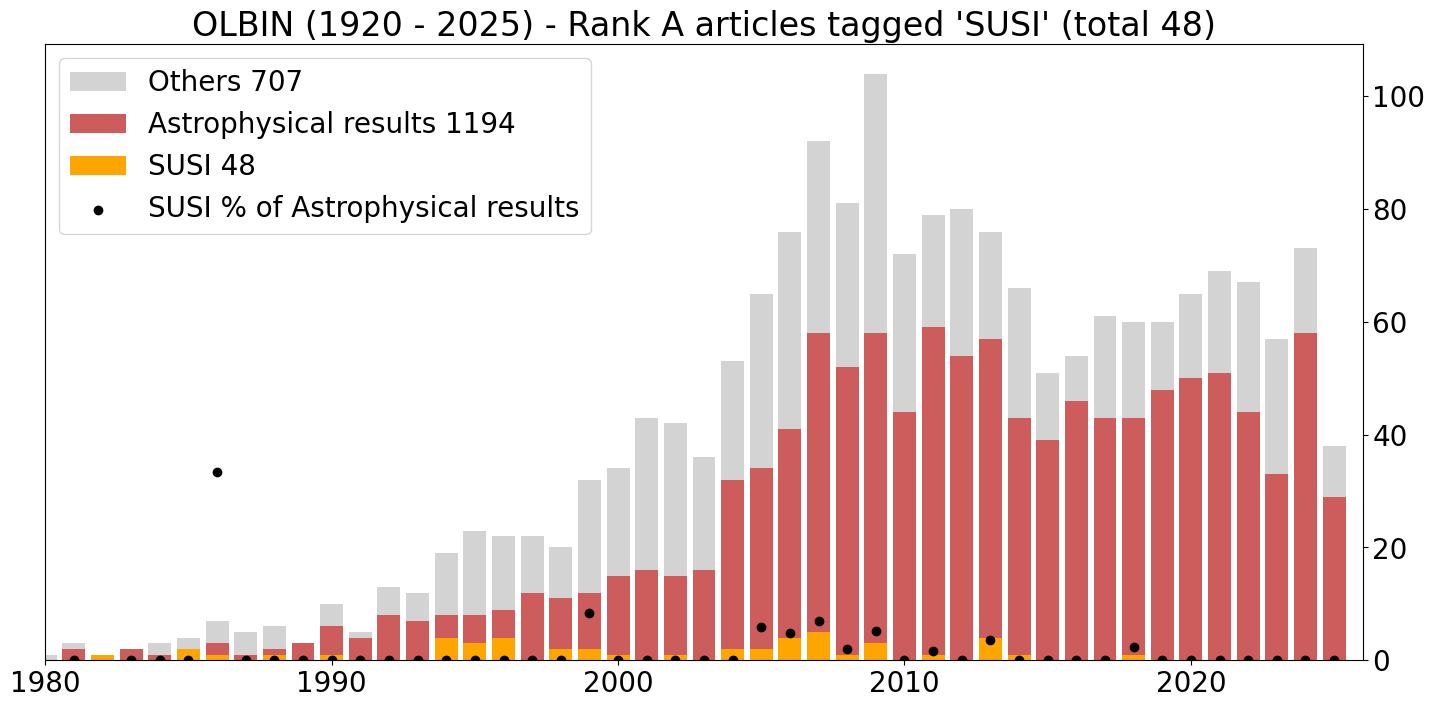

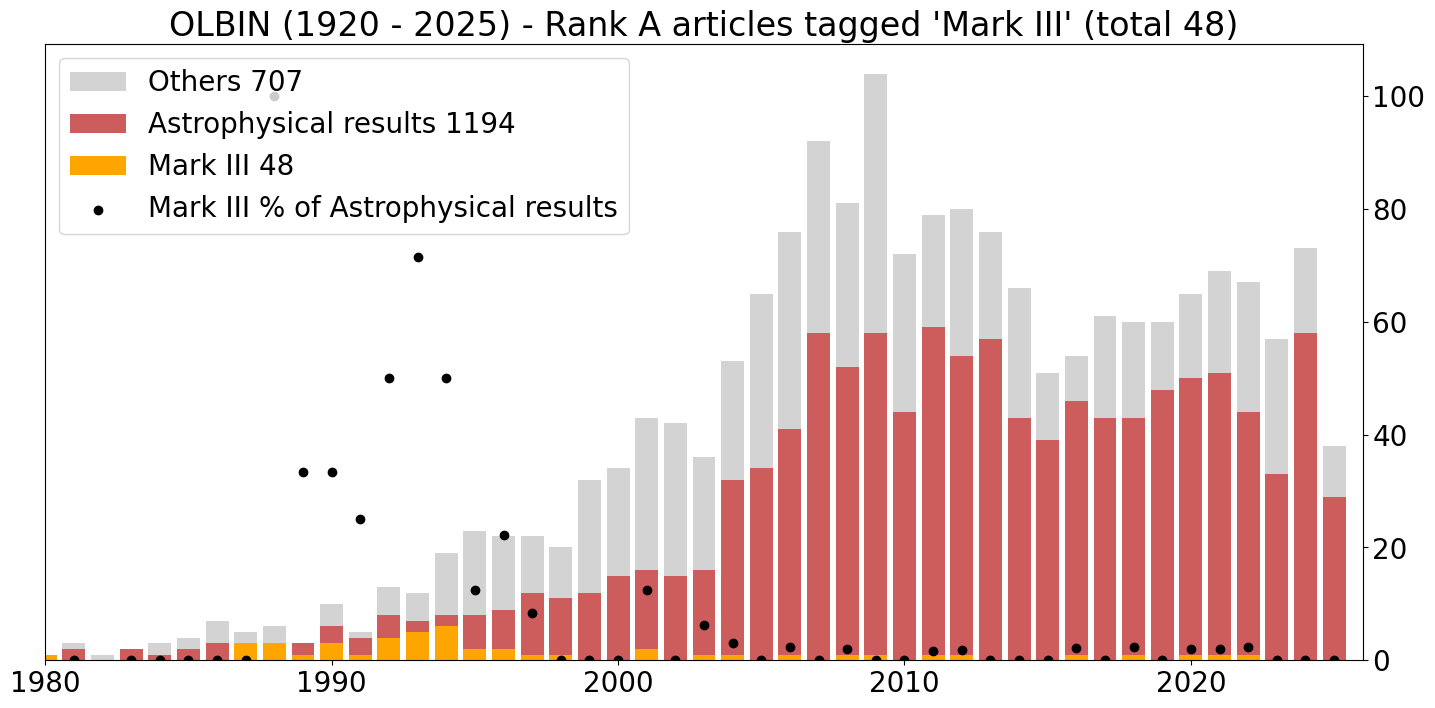

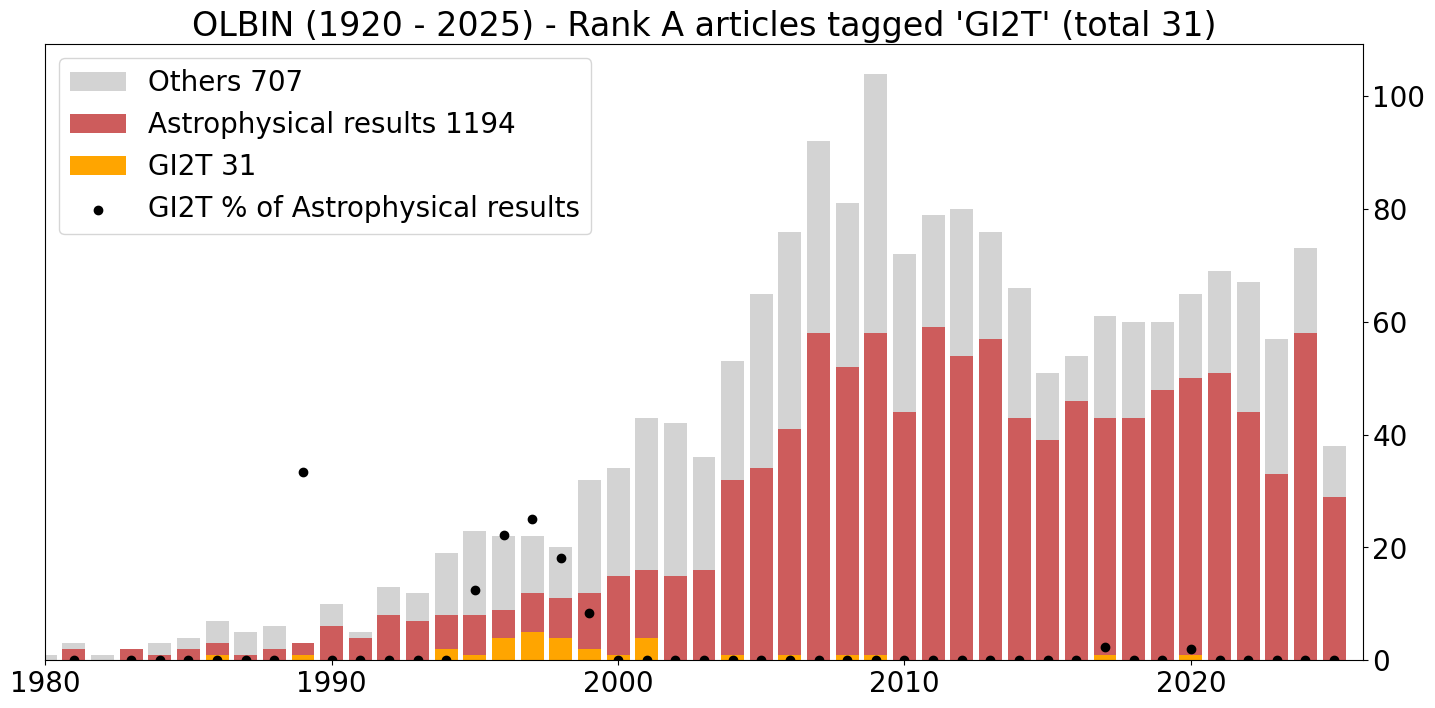

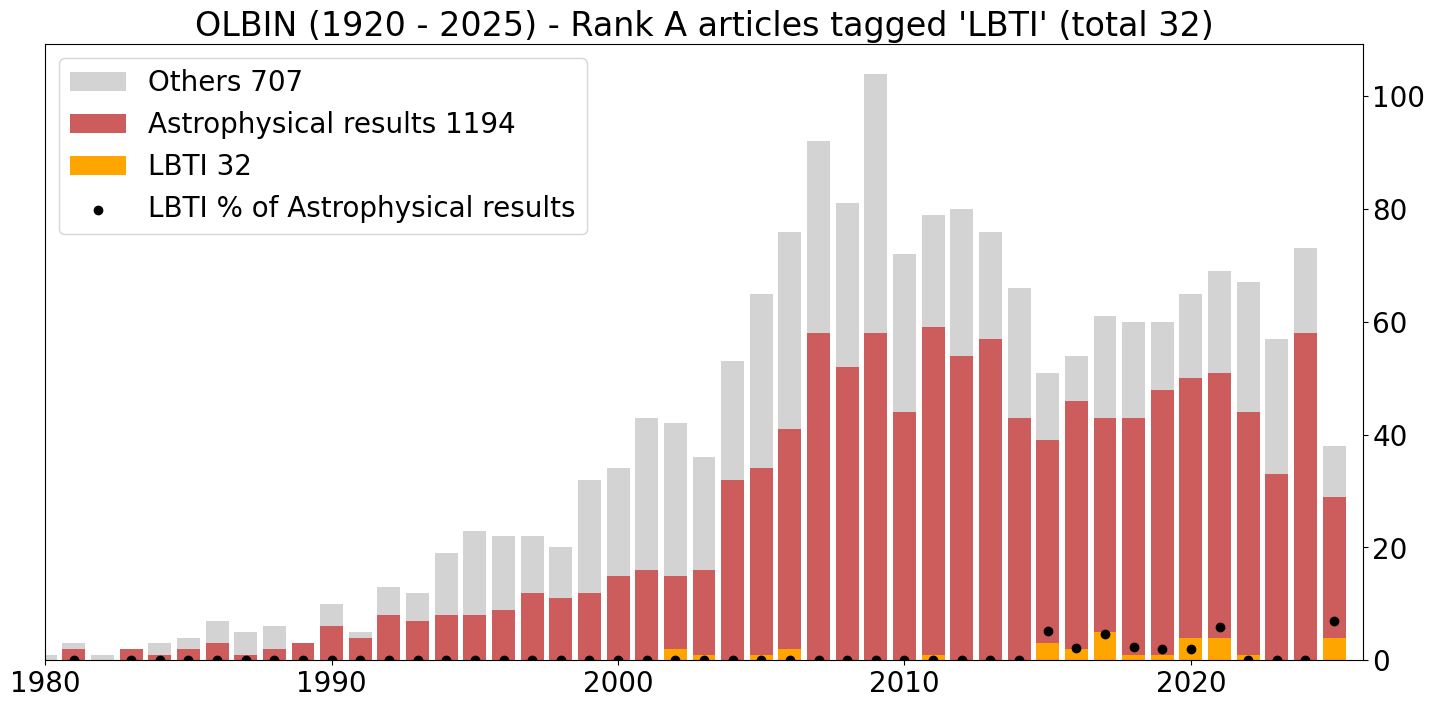

In [3]:
# reuse main datasource 
#olbin = pandas.read_csv("http://bibdbmgr.jmmc.fr/tags.xql")
from scipy.ndimage import gaussian_filter1d

add_percent=True #
tags=[]
tags.append(None) # None is added to compute first general diagram
tags.append("JMMC")
tags+=[c for c in categories["Facility"] if sum(olbin[c])>25]

columns=["YEAR", "total_pubs","Astrophysical results"]
#for tag in (None,"CHARA", "VLTI","JMMC"):
for tag in tags: 
    # create data sets
    s={}
    s1=s["Others"]=olbin.total_pubs
    s2=s["Astrophysical results"]=olbin["Astrophysical results"]
    if tag :        
        s3=s[tag]=olbin[tag]
        s3a=olbinAstro[tag]        
        s4=(100*s3a/s2)
        columns.append(tag)
    else:        
        s4=s["%"]=(100*s2/s1)    
    
    # figure
    fig, ax = plt.subplots()
    p1 = ax.bar(olbin.YEAR, s1, color='lightgrey')
    p2 = ax.bar(olbin.YEAR, s2, color='indianred')
    
    legends = ["Others "+str(sum(s1) - sum(s2)), "Astrophysical results "+str(sum(s2)) ]
    axes = [p1,p2]    
    if tag :
        p3 = ax.bar(olbin.YEAR, s3, color='orange')            
        op = ax.set_title("OLBIN (%s - %s) - Rank A articles tagged '%s' (total %d)"%(min(olbin.YEAR), max(olbin.YEAR), tag, sum(s3) ))                
        s3legend = tag+" "+str(sum(s3))
        s4legend = f"{tag} % of Astrophysical results"        
        legends.append(s3legend)
        axes.append(p3)
    else :
        op = ax.set_title("OLBIN (%s - %s) - Rank A articles (total %d)"%(min(olbin.YEAR), max(olbin.YEAR), sum(s1)))   
        s4legend = "Astrophysical results %"    
        
    
    
    if add_percent:        
        p4 = ax.scatter (olbin.YEAR, s4, color='black', marker='o')
        #p5 = ax.plot (olbin.YEAR, s4, color='black', linewidth=.7)
        legends.append(s4legend)
        axes.append(p4)        
                
    op = ax.legend(axes, legends, loc='upper left') 
    
        
    op = ax.set_xlim(1980,max(olbin.YEAR)+1)
    op = ax.yaxis.tick_right()

In [4]:
olbin[columns]

,YEAR,total_pubs,Astrophysical results,JMMC,VLTI,IOTA,PTI,CHARA,NPOI,ISI,Keck,SUSI,Mark III,GI2T,LBTI
0,2025,38,29,18,21,0,1,5,3,0,0,0,0,0,4
1,2024,73,58,43,47,1,3,16,1,0,2,0,0,0,0
2,2023,57,33,29,27,1,2,10,2,0,2,0,0,0,0
3,2022,67,44,34,37,0,1,16,3,0,2,0,1,0,1
4,2021,69,51,34,36,1,3,18,2,0,1,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,1964,1,1,0,0,0,0,0,0,0,0,0,0,0,0
59,1958,2,1,0,0,0,0,0,0,0,0,0,0,0,0
60,1956,2,1,0,0,0,0,0,0,0,0,0,0,0,0
61,1921,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
astro=olbinAstro[["YEAR", "Astrophysical results", "JMMC"]]
astro["JMMCPercent"]=olbinAstro["JMMC"]/olbinAstro["Astrophysical results"]
astro

/var/folders/sk/q8hg_qfx7bl8wtg316svc_lc0000gn/T/ipykernel_3414/1064694839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  astro["JMMCPercent"]=olbinAstro["JMMC"]/olbinAstro["Astrophysical results"]


,YEAR,Astrophysical results,JMMC,JMMCPercent
0,2025,29,15,0.517241
1,2024,58,40,0.689655
2,2023,33,21,0.636364
3,2022,44,32,0.727273
4,2021,51,34,0.666667
...,...,...,...,...
58,1964,1,0,0.000000
59,1958,1,0,0.000000
60,1956,1,0,0.000000
61,1921,1,0,0.000000


# Look at facilities

5 xticks for 1960 2026


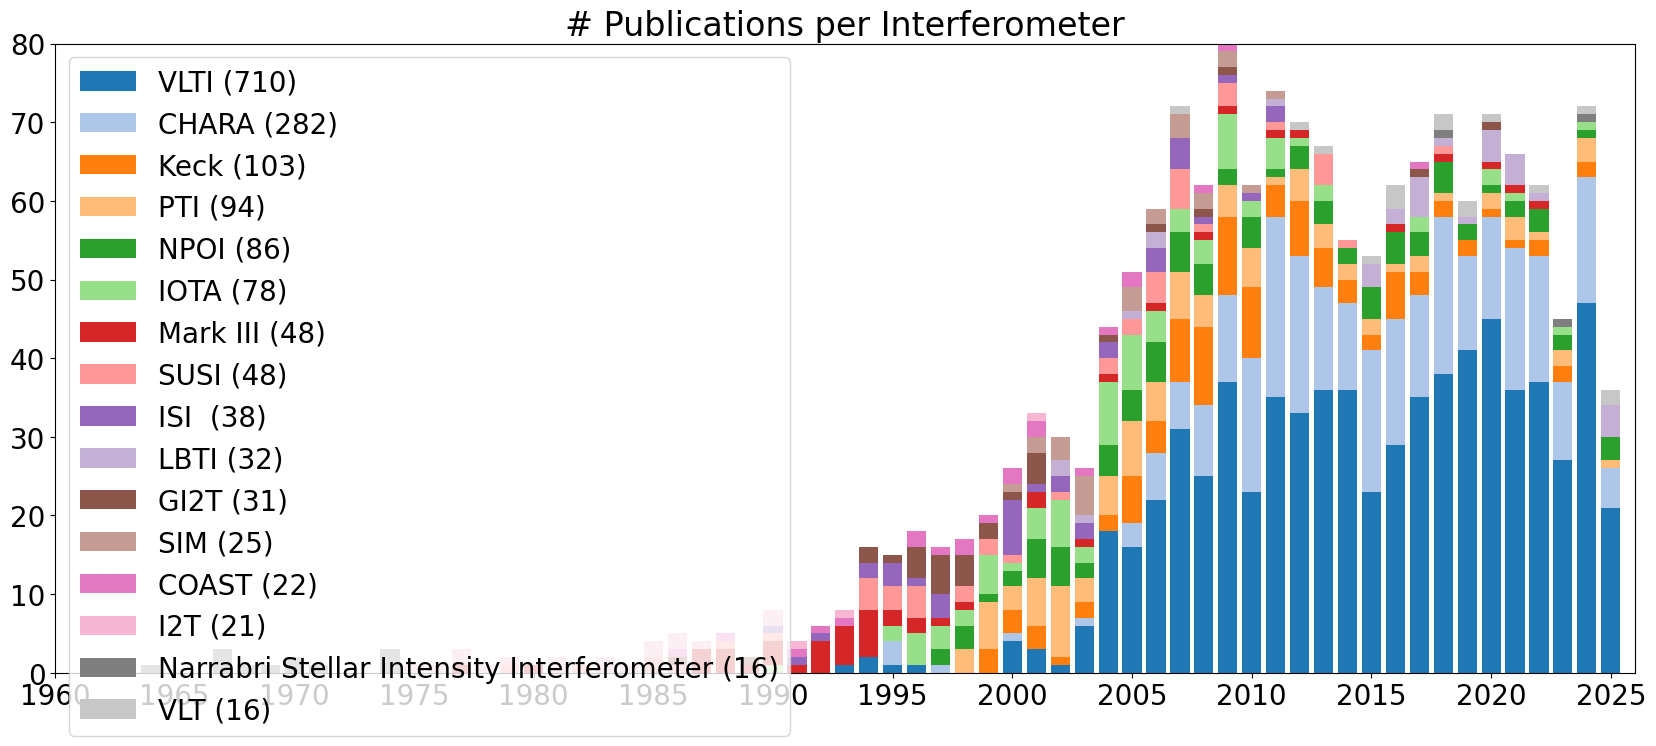

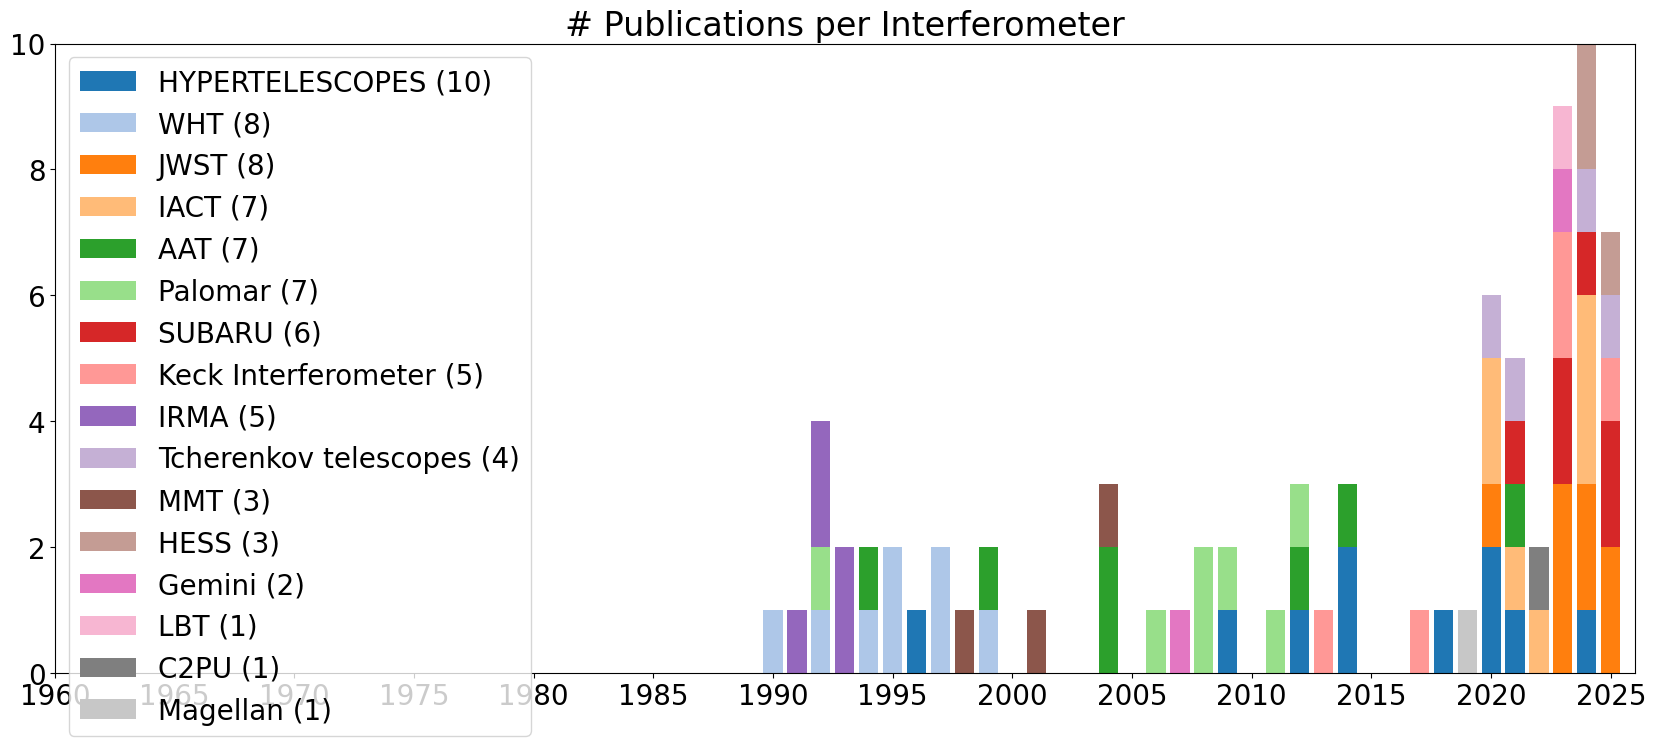

In [6]:
plotStackedOlbinTags(categories["Facility"], "# Publications per Interferometer", 1960)

2 xticks for 1995 2026


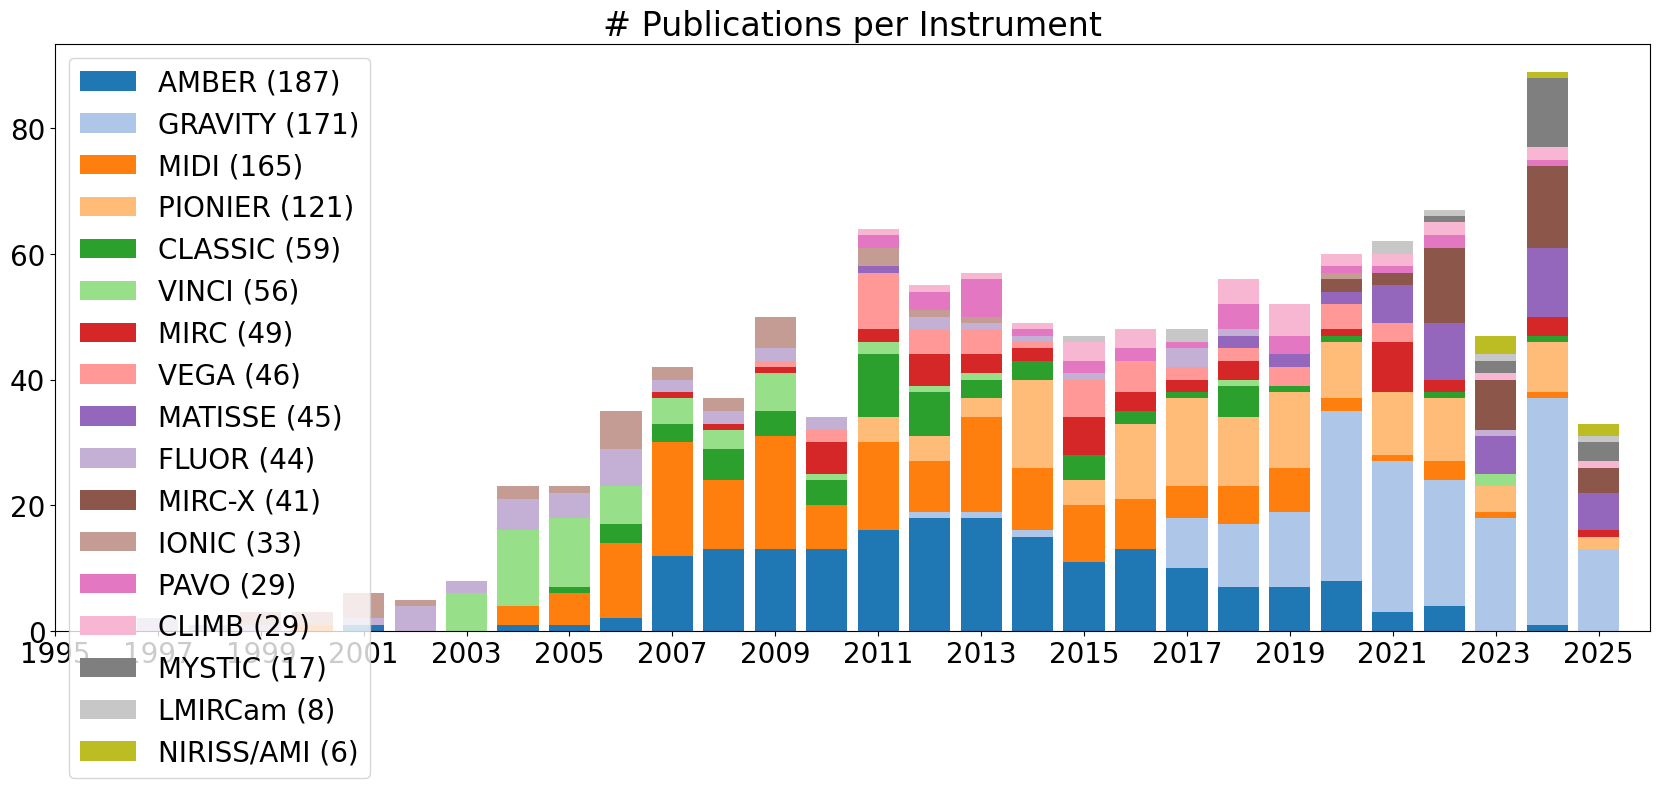

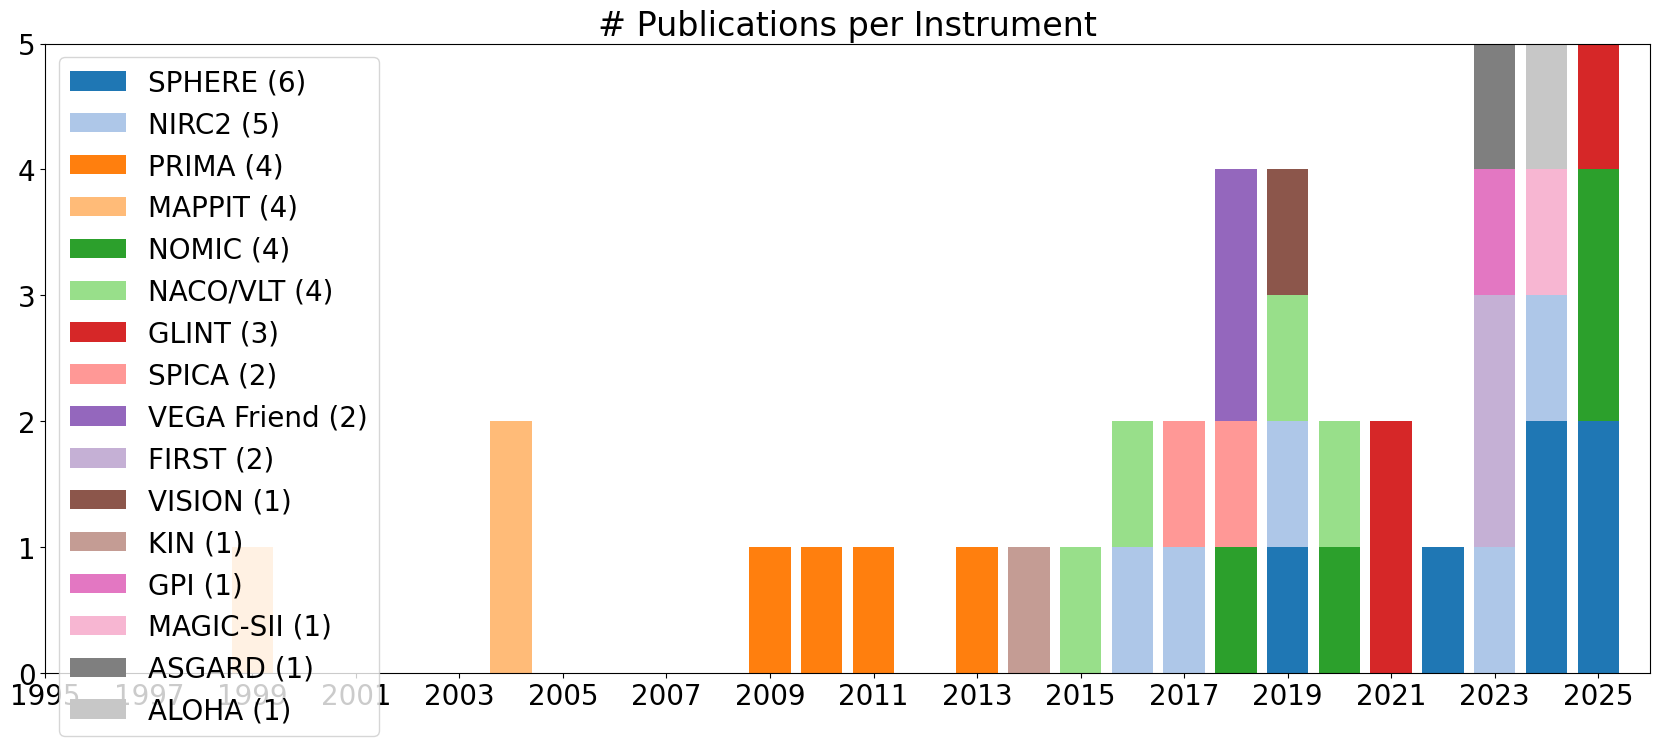

In [7]:
plotStackedOlbinTags(categories["Instrument"], "# Publications per Instrument", 1995)

# Follow JMMC products cited in the OLBIN corpus

1 xticks for 2003 2026


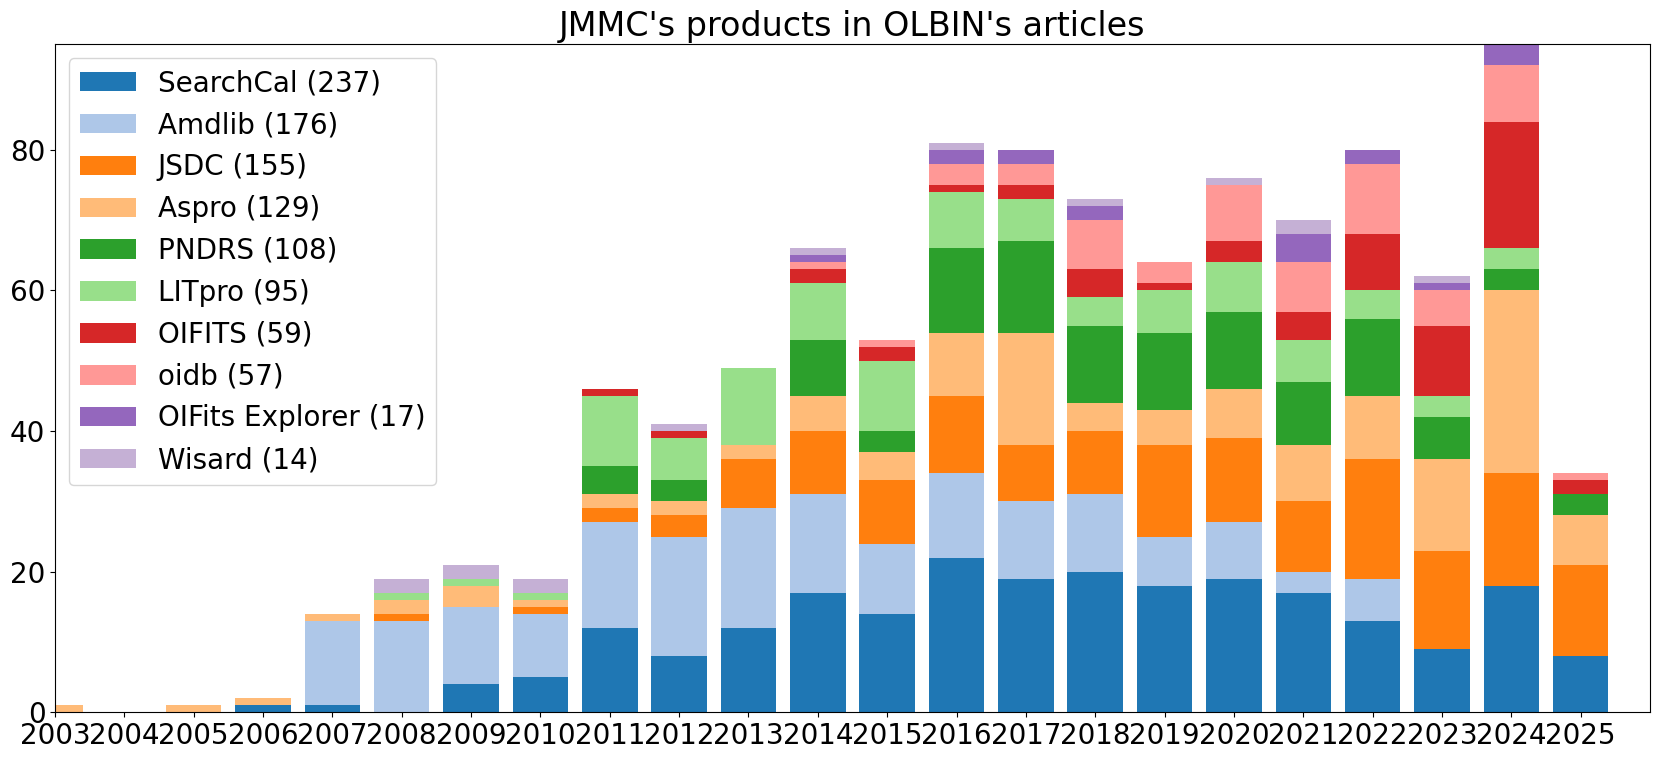

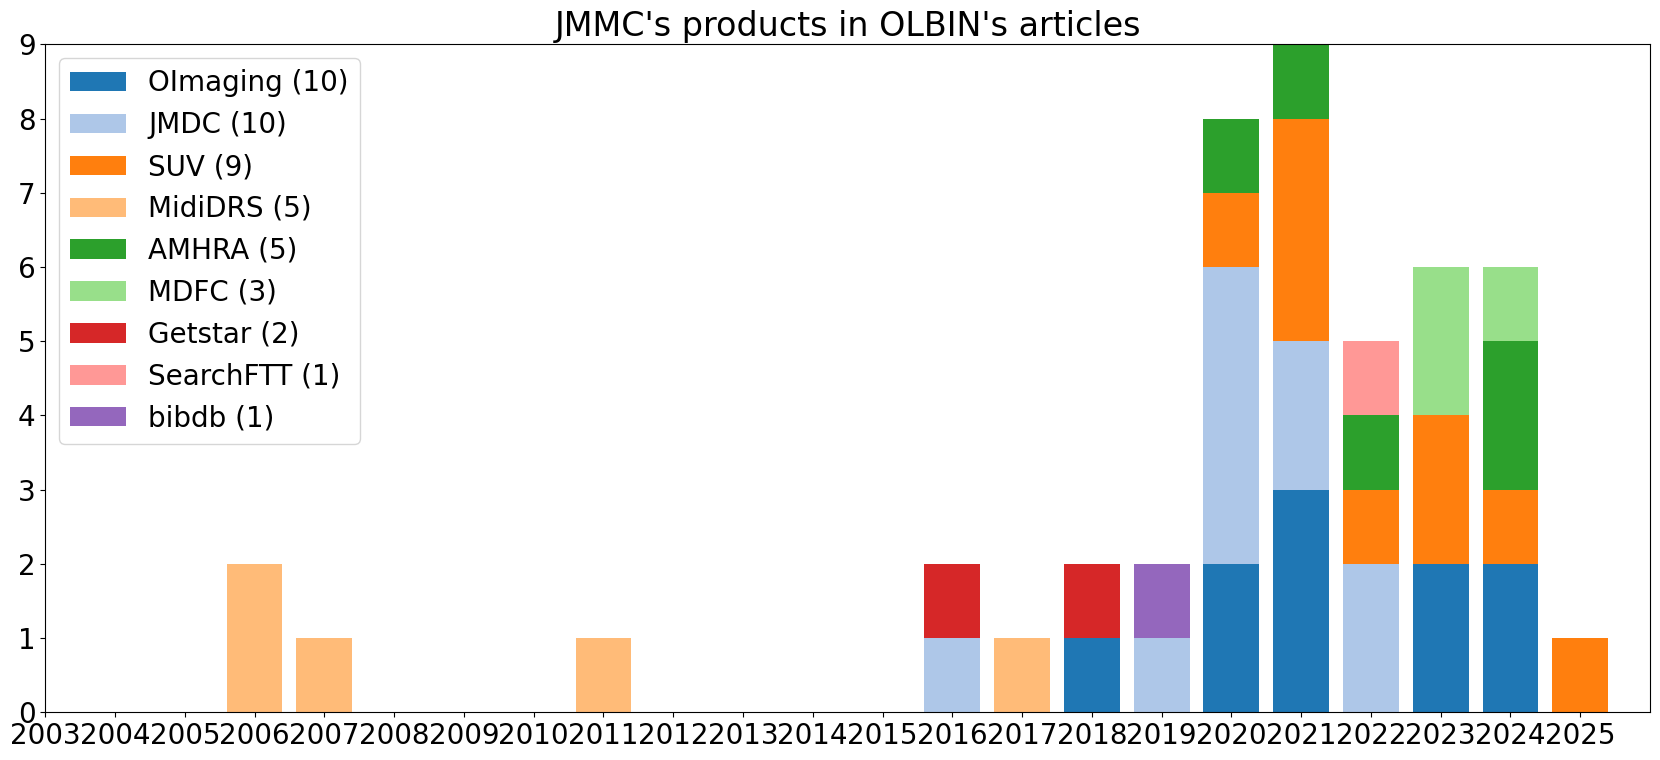

In [8]:
tags = [tag for tag in categories["HIDDEN"] if not "JMMC" in tag]  # Filter JMMC out
plotStackedOlbinTags( tags ,"JMMC's products in OLBIN's articles", 2003)

2 xticks for 1995 2026


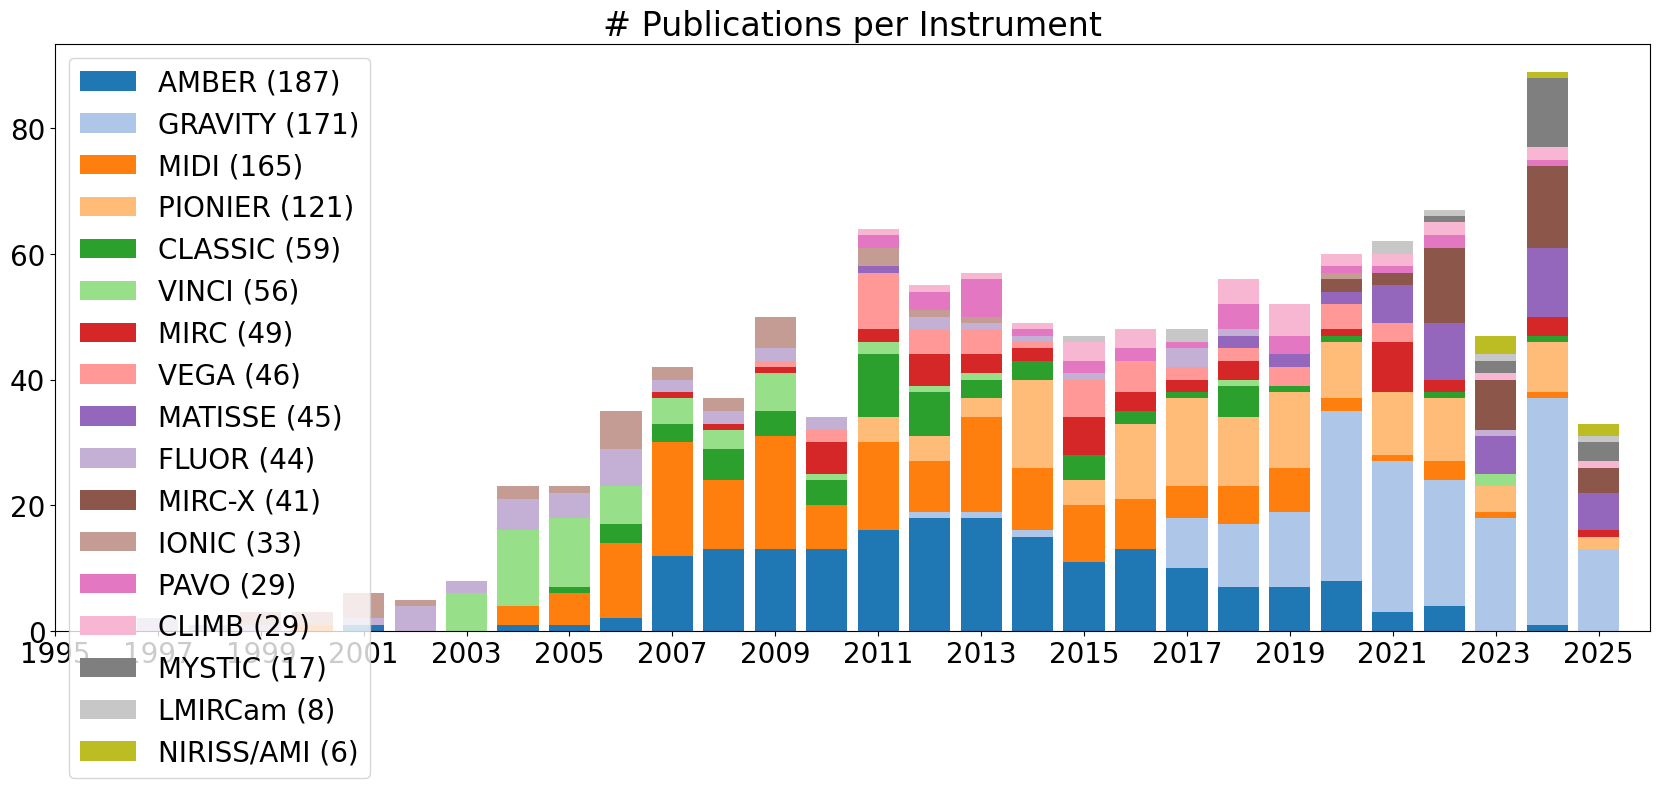

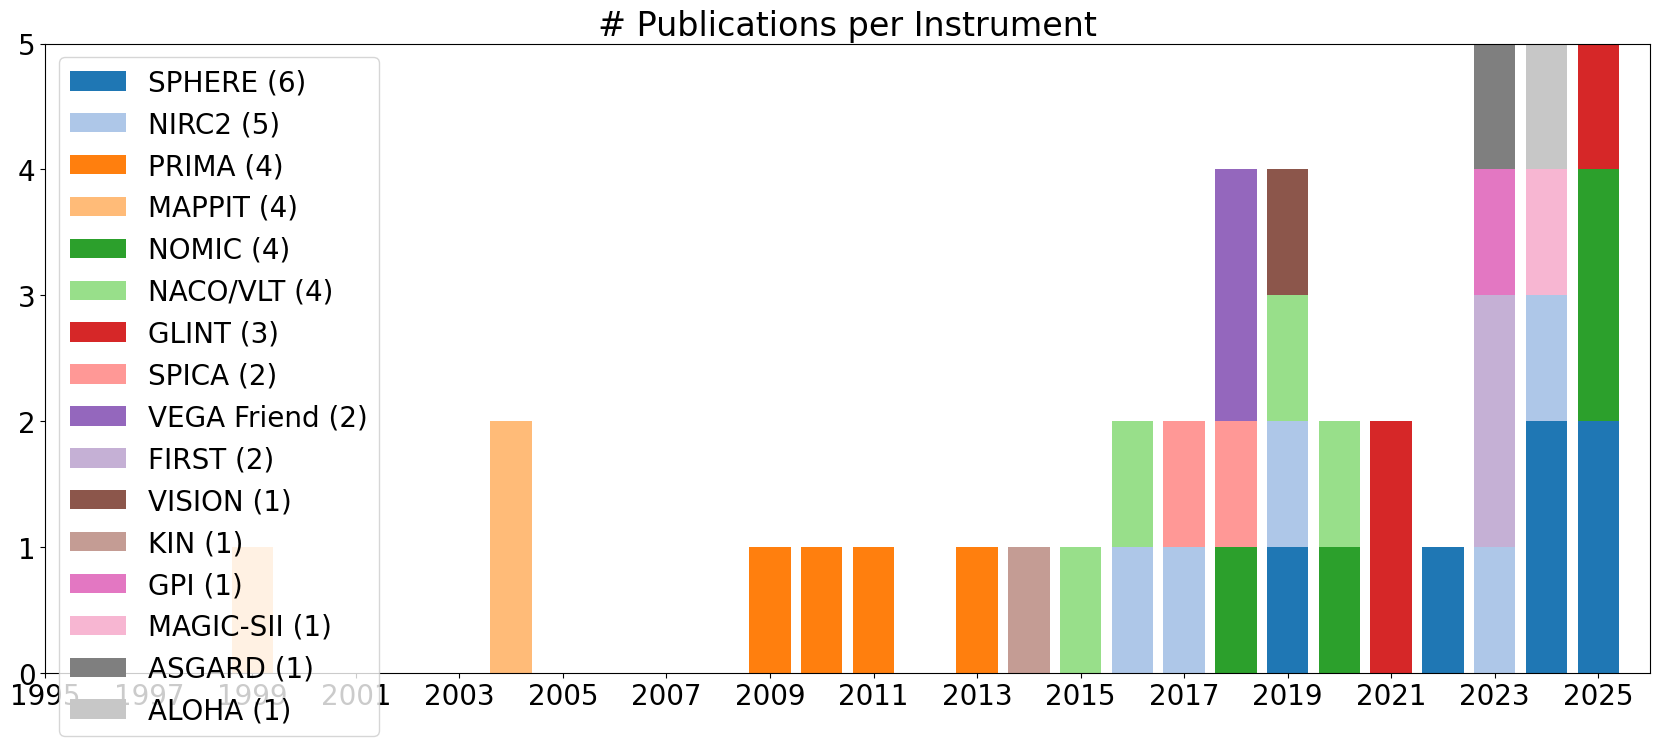

In [9]:
plotStackedOlbinTags(categories["Instrument"], "# Publications per Instrument", 1995)

2 xticks for 1995 2026


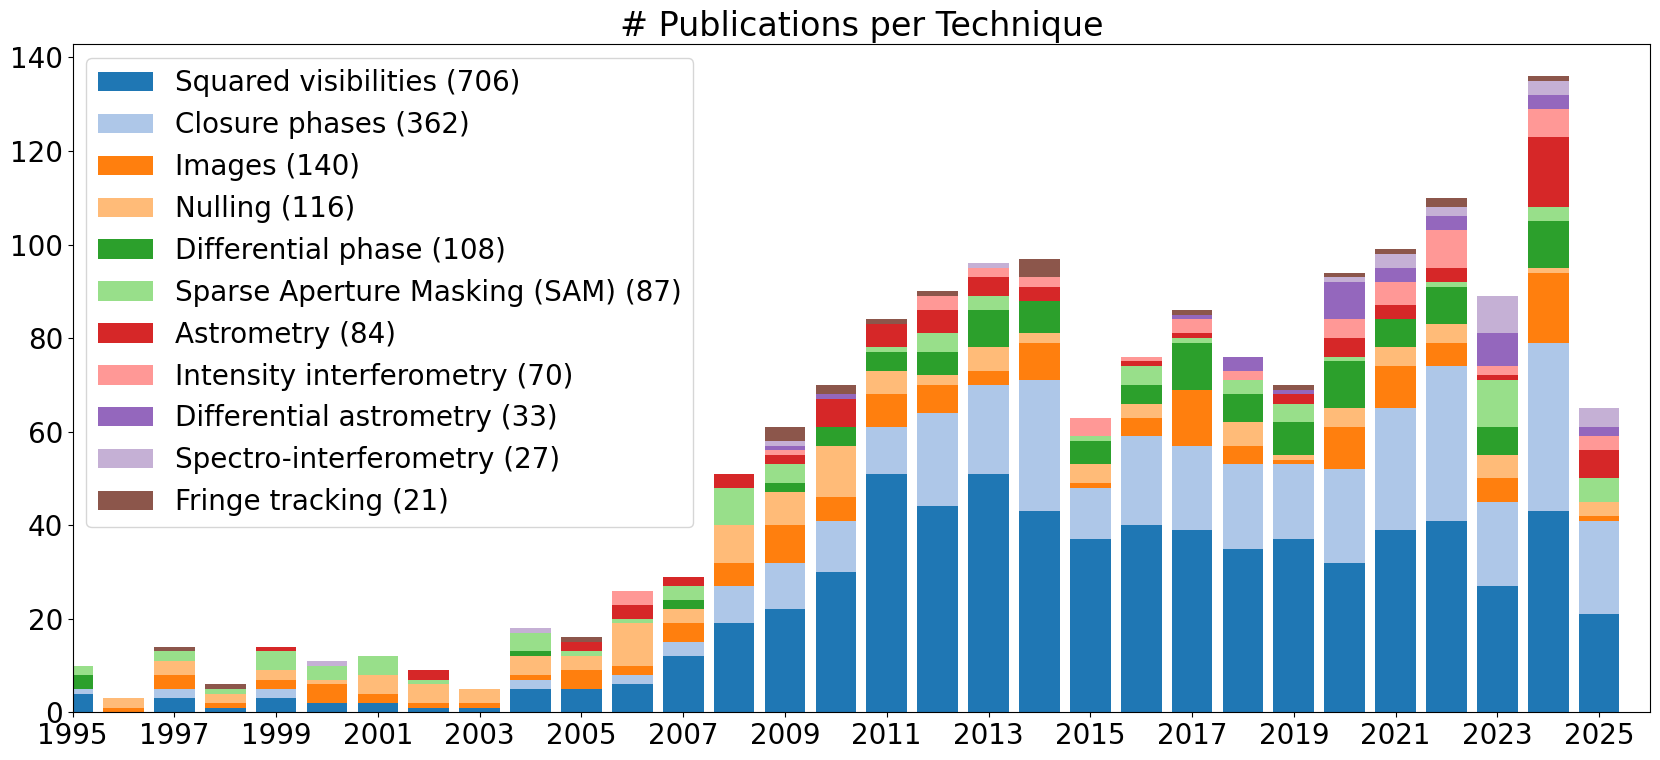

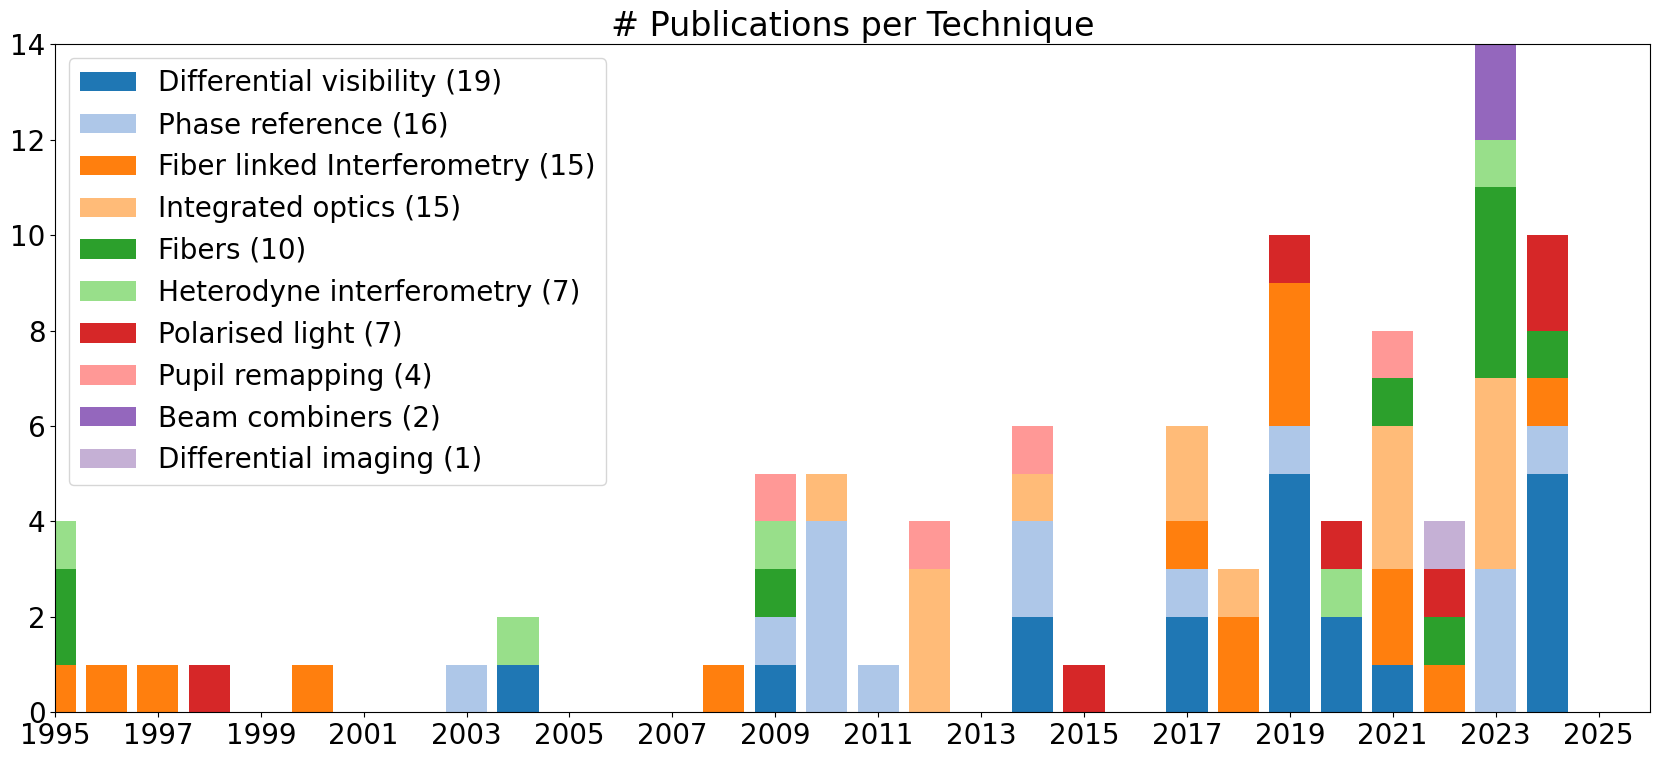

In [10]:
plotStackedOlbinTags(categories["Technique"], "# Publications per Technique", 1995)